# Project 02: CONVERSION RATE CHALLENGE
## Bloc n°3 - Jedha - dsmft - Paris14
### Nicolas Hegerle

## Library imports and function definition

### <ins>Import the necessary libraries for the project</ins>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay

from xgboost import XGBClassifier
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

### <ins>Fuction definition (for later)</ins>

In [2]:
#Define a function to test multiple models with default parameters against the baseline model

def classif_model_testing(X_train, X_test, Y_train, Y_test):
    
    #Instanciation of the classes
    lr_classif = LogisticRegression()
    ridge_classif = RidgeClassifier()
    dt_classif = DecisionTreeClassifier()
    svc_classif = SVC()
    ab_classif = AdaBoostClassifier()
    bag_classif = BaggingClassifier()
    gb_classif = GradientBoostingClassifier()
    rf_classif = RandomForestClassifier()
    xgb = XGBClassifier()
    
    models = {
        'LogReg' : lr_classif, \
        'Ridge' : ridge_classif, \
        'DecisionTree' : dt_classif, \
        'SVC' : svc_classif, \
        'AdaBoost' : ab_classif, \
        'Bagging' : bag_classif, \
        'GradBoost' : gb_classif, \
        'Random_Forest' : rf_classif, \
        'XGBoost' : xgb
    }
    
    scores = {}
    f1_test_scores = {}
    
    for name, classifier in models.items():
        #train the classifier on the train set and perform cross-validation
        classifier.fit(X_train, Y_train)
        cv_score = cross_val_score(classifier, X5_train, y5_train, cv = 5, scoring = 'f1')
             
        #get the f1 score and confusion matrix on the train set
        Y_train_pred = classifier.predict(X_train)
        mean_f1_score_train = cv_score.mean()
        std_f1_score_train = cv_score.std()
        conf_mat_train = confusion_matrix(Y_train, Y_train_pred)
        
        #get f1 score and confusion matrix on the test set
        Y_test_pred = classifier.predict(X_test)
        f1_score_test = f1_score(Y_test, Y_test_pred)
        conf_mat_test = confusion_matrix(Y_test, Y_test_pred)
        
        scores[name] = {
            'mean_f1_train' : mean_f1_score_train, \
            'std_f1_train' : std_f1_score_train, \
            'f1_test' : f1_score_test, \
            'c_mat_train' : conf_mat_train, \
            'c_mat_test' : conf_mat_test
        }
        
        f1_test_scores[classifier] = f1_score_test
        
    scores = pd.DataFrame(scores)
    
    best_classifier = max(f1_test_scores, key=f1_test_scores.get)
        
    return scores, best_classifier   

## Part I: data loading and exploration

### <ins>Load the dataset and print basic statistics</ins>

In [3]:
data = pd.read_csv('conversion_data_train.csv')
print(f"Set with labels: {data.shape[0]} rows for {data.shape[1]} columns")
print("\nFirst few rows of the dataframe:")
display(data.head())

Set with labels: 284580 rows for 6 columns

First few rows of the dataframe:


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
# print out a statistical description of the data
print('\nDescription of the dataset:')
display(data.describe(include = 'all'))

# count the proportion of missing values in the dataset
print('\nCount of missing values per columns:')
for col in data.columns:
    n_missing = data.loc[ : , col].isna().sum()
    missing = n_missing / data.shape[0] * 100
    print('There are {} missing, which is {}% of the values.'.format(n_missing, round(missing, 2)))


Description of the dataset:


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Count of missing values per columns:
There are 0 missing, which is 0.0% of the values.
There are 0 missing, which is 0.0% of the values.
There are 0 missing, which is 0.0% of the values.
There are 0 missing, which is 0.0% of the values.
There are 0 missing, which is 0.0% of the values.
There are 0 missing, which is 0.0% of the values.


- <font size = 5>No missing values in the dataset</font>
- <font size = 5>Categorical features = country, new_user, source</font> <br>
- <font size = 5>Numerical features = age, total_pages-visited</font> <br>
- <font size = 5>Target = converted</font>

### <ins>Graphical Exploratory Data Analysis</ins>

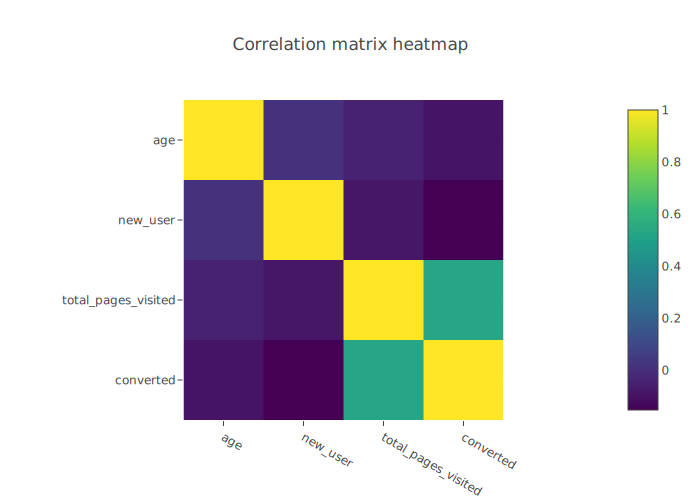

In [5]:
# plot a correlation matrix of the numeric variables
px.imshow(data.corr(), title = 'Correlation matrix heatmap')

- <font size = 5>The total number of pages visited has the strongest positive correlation with the conversion</font>
- <font size = 5>Being a new user seems to have a negative correlation with the conversion</font>
- <font size = 5>No other strong inter-variable correlation </font>

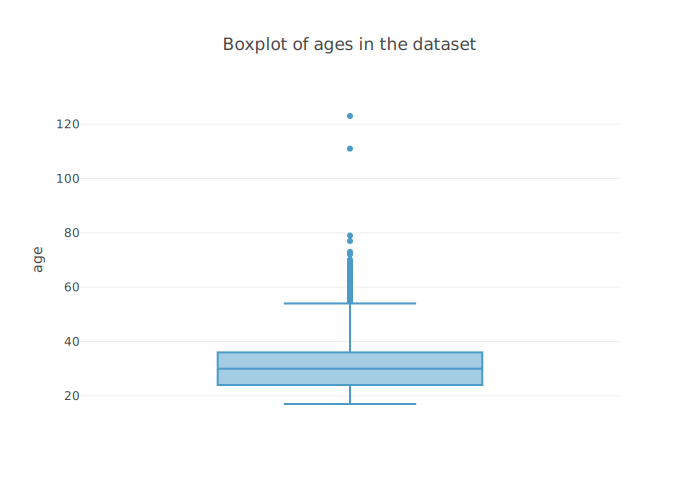

In [6]:
px.box(data, y = 'age', title = 'Boxplot of ages in the dataset')

- <font size = 5>Seems like there might be a few mistakes or very old users...We can drop outliers, i.e. age > 3*std</font>

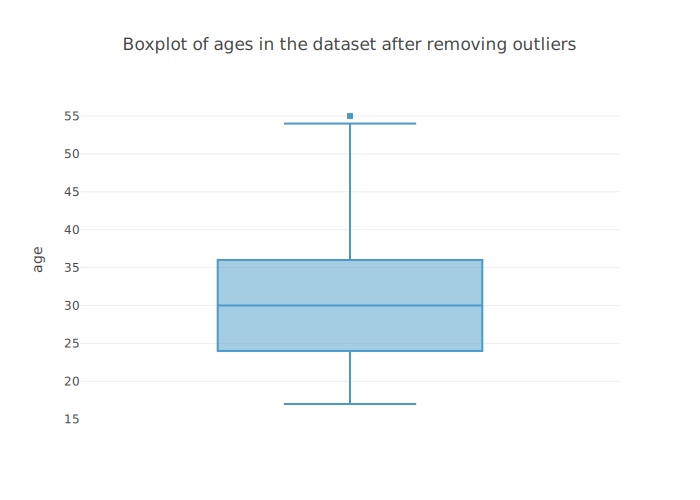

In [7]:
mask = data['age'] <= data['age'].mean() + 3*data['age'].std()
data = data.loc[mask]
px.box(data, y = 'age', title = 'Boxplot of ages in the dataset after removing outliers')

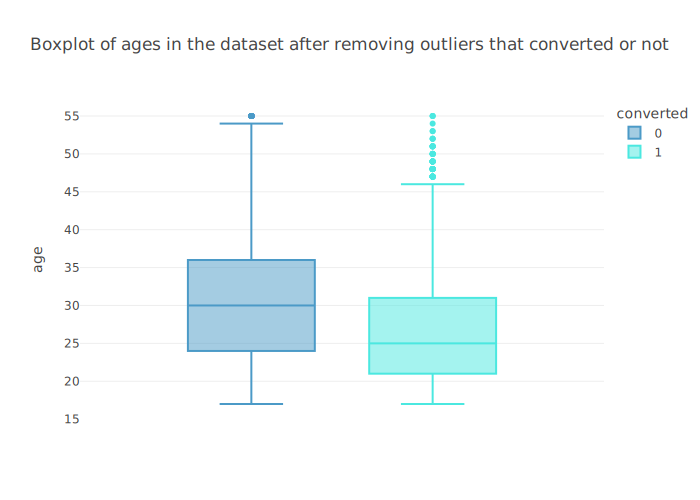

In [8]:
px.box(data, y = 'age', color = 'converted', title = 'Boxplot of ages in the dataset after removing outliers that converted or not')

- <font size = 5>People that converted are a bit youger</font>

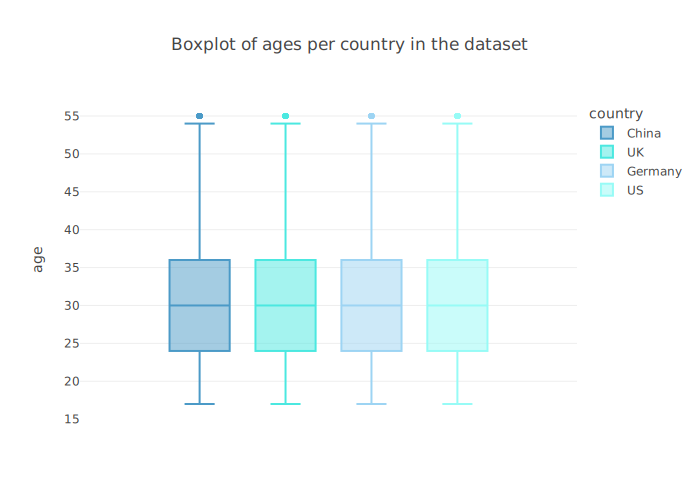

In [9]:
px.box(data, y = 'age', color = 'country', title = 'Boxplot of ages per country in the dataset')

- <font size = 5>There is no differenc in age distribution between the countries so if there is a different impact of the country of origin it is not relatd to age</font>

The conversion metrics per country are as follows:
Country: China. Total converted: 89. Total rows: 68877. Conversion rate: 0.13%
Country: Uk. Total converted: 2289. Total rows: 43504. Conversion rate: 5.26%
Country: Germany. Total converted: 729. Total rows: 11654. Conversion rate: 6.26%
Country: Us. Total converted: 6066. Total rows: 159528. Conversion rate: 3.8%


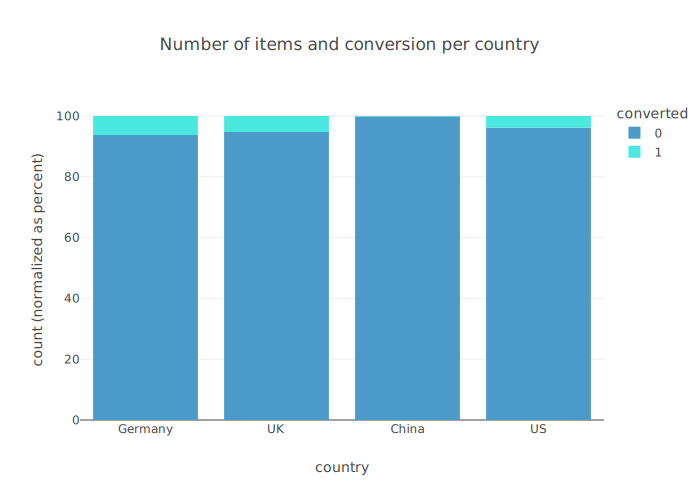

In [10]:
#Plot a histogram of the countries with conversion rate
fig = px.histogram(data, x = 'country', color = 'converted', \
                   category_orders=dict(country=["Germany", "UK", "China", "US"]), \
                   title = 'Number of items and conversion per country', \
                   barnorm = 'percent'
                  )

#Calculate the conversion rate per country
print('The conversion metrics per country are as follows:')
for c in data.country.unique():
    mask = data.country == c
    n_converted = data.loc[mask]['converted'].sum()
    total_items = data.loc[mask].shape[0]
    c_rate = n_converted / total_items * 100
    print('Country: {}. Total converted: {}. Total rows: {}. Conversion rate: {}%'.format(str(c).title(), n_converted, total_items, round(c_rate, 2)))

fig.show()

- <font size = 5>Germany and UK have the highest conversion rates. US is over-represented with 160124 rows in the dataframe.</font>

The conversion metrics per source are as follows:
Source: Direct. Total converted: 1810. Total rows: 64838. Conversion rate: 2.79%
Source: Ads. Total converted: 2783. Total rows: 79735. Conversion rate: 3.49%
Source: Seo. Total converted: 4580. Total rows: 138990. Conversion rate: 3.3%


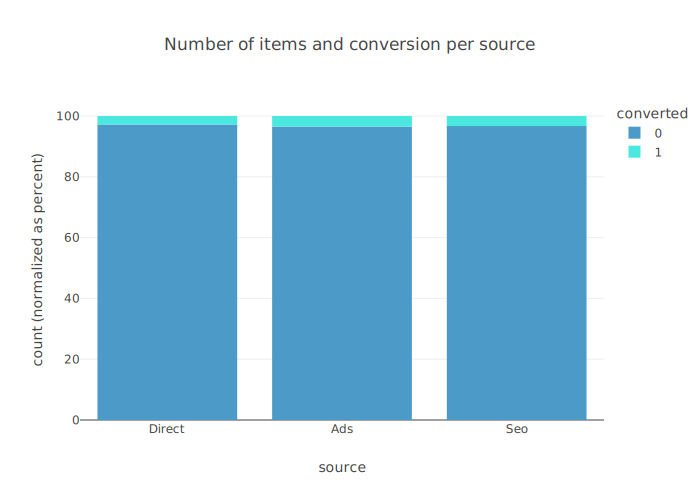

In [11]:
#Plot histogtram of the source with conversion rate
fig = px.histogram(data, x = 'source', \
                   color = 'converted', \
                   title = 'Number of items and conversion per source', \
                   barnorm = 'percent'
                  )

#Calculate the conversion rate per source
print('The conversion metrics per source are as follows:')
for s in data.source.unique():
    mask = data.source == s
    n_converted = data.loc[mask]['converted'].sum()
    total_items = data.loc[mask].shape[0]
    c_rate = n_converted / total_items * 100
    c_rate = data.loc[mask]['converted'].sum() / data.loc[mask].shape[0] * 100
    print('Source: {}. Total converted: {}. Total rows: {}. Conversion rate: {}%'.format(str(s).title(), n_converted, total_items, round(c_rate, 2)))

fig.show()

- <font size = 5>Ads have a higher conversion rate but not by much</font>

New user: Yes. Total converted: 2738. Total rows: 194366. Conversion rate: 1.41%
New user: No. Total converted: 6435. Total rows: 89197. Conversion rate: 7.21%
New users represent 68.54% of all users


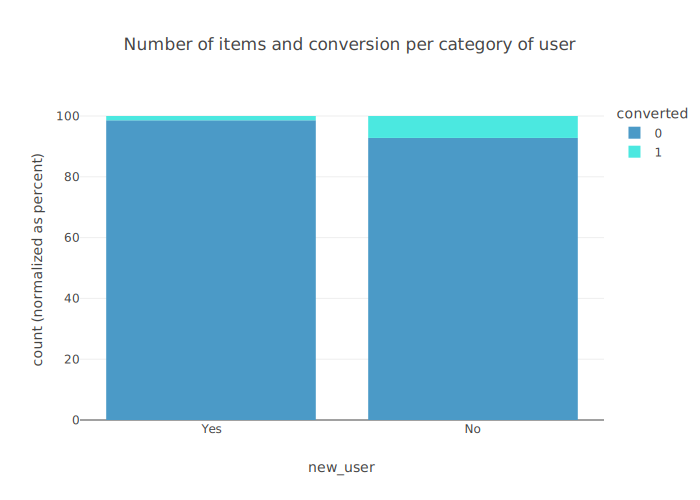

In [12]:
#Plot histogtram of the new users with conversion rate
data_recoded = data[['new_user', 'converted']]
data_recoded['new_user'] = data_recoded['new_user'].apply(lambda x : 'Yes' if x ==1 else 'No')
fig = px.histogram(data_recoded, x = 'new_user', \
                   color = 'converted', \
                   category_orders=dict(new_user=[0, 1]), \
                   title = 'Number of items and conversion per category of user', \
                   barnorm = 'percent'
                  )

for n in data_recoded.new_user.unique():
    mask = data_recoded.new_user == n
    n_converted = data_recoded.loc[mask]['converted'].sum()
    total_items = data_recoded.loc[mask].shape[0]
    c_rate = n_converted / total_items * 100
    print('New user: {}. Total converted: {}. Total rows: {}. Conversion rate: {}%'.format(n.title(), n_converted, total_items, round(c_rate, 2)))

print(f"New users represent {round(data['new_user'].sum()/data.shape[0]*100, 2)}% of all users")

fig.show()

- <font size = 5>Older users have a higher conversion rate than newbies but there are less of them</font>

## Part II: Dummy model and Train a baseline model (provided by Jedha)

### <ins>Dummy model always predicting the most frequent target</ins>

In [13]:
# how would a dummy model perform on this data set
dmc = DummyClassifier(strategy='most_frequent')
y = data['converted']
X = data['new_user'].values

dmc.fit(X, y)
y_pred = dmc.predict(X)
print("f1-score of the dummy model: ", f1_score(y, y_pred))
print("accuracy score of the dummy model: ", accuracy_score(y, y_pred))

f1-score of the dummy model:  0.0
accuracy score of the dummy model:  0.9676509276598145


- <font size = 5>Well that is not great!!!</font>

### <ins>Baselin model trained on total number of pages visited only</ins>

In [14]:
# start with the total number of pages visted
features_list = ['total_pages_visited']
numeric_indices = [0]
target_variable = 'converted'

# define the target and the features
X = data.loc[:, features_list]
y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



In [15]:
# Divide the dataset in Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify = y)
print("...Done.")
print()

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Converting pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print(f"X-train: {X_train[0:3,:]}")
print(f"X-test: {X_test[0:3,:]}")
print()
print(f"y-train: {y_train[0:3]}")
print(f"y-test: {y_test[0:3]}")

Dividing into train and test sets...
...Done.

Converting pandas DataFrames to numpy arrays...
...Done
X-train: [[6]
 [6]
 [7]]
X-test: [[4]
 [5]
 [5]]

y-train: [0 0 0]
y-test: [0 0 0]


In [16]:
# Preprocessing pipeline
print("Standardizing numerical features of the train set...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(f"Standardized X-train: {X_train[0:3,:]}")

# Standardize the features on the test set using the fitted featureencoder
print("Standardizing numerical features of the test set...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(f"Standardized X-test: {X_test[0:5,:]}")

Standardizing numerical features of the train set...
...Done
Standardized X-train: [[0.33555591]
 [0.33555591]
 [0.63434609]]
Standardizing numerical features of the test set...
...Done
Standardized X-test: [[-0.26202446]
 [ 0.03676573]
 [ 0.03676573]
 [ 1.53071665]
 [-0.56081464]]


In [17]:
# Train the baseline model
print("Training the model...")
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print("...Done.")

# Perform predictions on training set
print("Predictions on training set...")
y_train_pred = classifier.predict(X_train)
print("...Done.")
print(f"y-train predictions: {y_train_pred}")
print()

# Perform predictions on test set
print("Predictions on test set...")
y_test_pred = classifier.predict(X_test)
print("...Done.")
print(f"y-test predictions: {y_test_pred}")
print()

Training the model...
...Done.
Predictions on training set...
...Done.
y-train predictions: [0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
y-test predictions: [0 0 0 ... 0 0 0]



f1-score on train set :  0.6981763426468128
f1-score on test set :  0.6868020304568527
Confusion matrix on train set : 


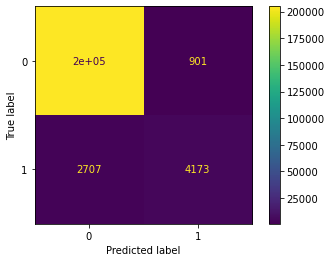


Confusion matrix on test set : 


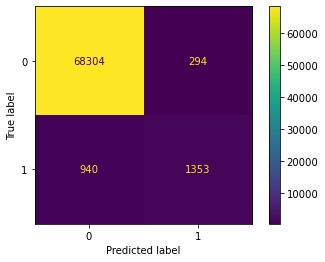

In [18]:
# lets asses the performance of the baseline model using the f1-score required for the challenge
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

# Check the confusion matrices to better understanf the model
print("Confusion matrix on train set : ")
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=classifier.classes_)
disp_train.plot()
plt.show()
print()
print("Confusion matrix on test set : ")
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classifier.classes_)
disp_test.plot()
plt.show()

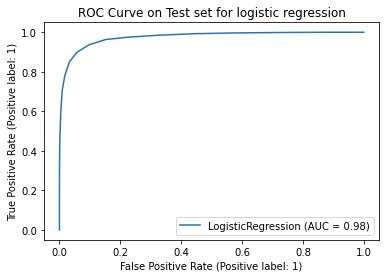

In [19]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set for logistic regression")
RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()


## Part III: Improvement of the model

### <ins>Feature importance and prediction performance with XGBoost</ins>

In [20]:
# dummify the categorical features using pandas
dummified_data = data.join(pd.get_dummies(data[['country', 'source']], drop_first=True))
dummified_data.drop(['country', 'source'], axis = 1, inplace=True) #remove original feature columns
print("First rows of the dummified dataframe:")
display(dummified_data.head())

# split the dataset in features and target
X = dummified_data[[col for col in dummified_data.columns if col != 'converted']]
X = X.values
print(f"Features before standardization: {X[0:3, :]}")
y = dummified_data['converted']
y = y.values
print(f"Target: {y[0:3]}")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)
print(f"Features after standard scaler: {X_train[0:3, :]}")



First rows of the dummified dataframe:


,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,22,1,2,0,0,0,0,1,0
1,21,1,3,0,0,1,0,0,0
2,20,0,14,1,1,0,0,0,1
3,23,1,3,0,0,0,1,0,1
4,28,1,3,0,0,0,1,1,0


Features before standardization: [[22  1  2  0  0  0  1  0]
 [21  1  3  0  1  0  0  0]
 [20  0 14  1  0  0  0  1]]
Target: [0 0 1]
Features after standard scaler: [[ 1.17745176  0.67786914  0.33555591 -0.20690916  2.35076226 -1.13450025
  -0.5451022  -0.98064543]
 [ 0.56066916  0.67786914  0.33555591 -0.20690916 -0.42539393  0.88144538
  -0.5451022   1.01973656]
 [ 1.79423436  0.67786914  0.63434609 -0.20690916 -0.42539393 -1.13450025
  -0.5451022   1.01973656]]


[18:48:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


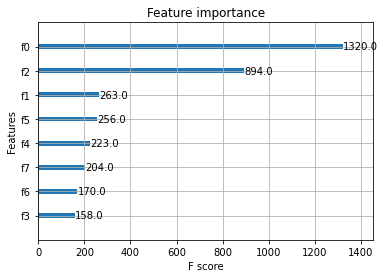

Features associated to there XGB index:
{'f0': 'age', 'f1': 'new_user', 'f2': 'total_pages_visited', 'f3': 'country_Germany', 'f4': 'country_UK', 'f5': 'country_US', 'f6': 'source_Direct', 'f7': 'source_Seo'}


In [21]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
plot_importance(xgb)
plt.show()

# retrieve feature indexes as presented by XGboost
features = {}
for index, col in enumerate(dummified_data[[col for col in dummified_data.columns if col != 'converted']].columns):
    features[f'f{index}'] = col
print("Features associated to there XGB index:")
print(features)

f1-score on train set :  0.7775111964171466
f1-score on test set :  0.7526934378060725
Confusion matrix on train set : 


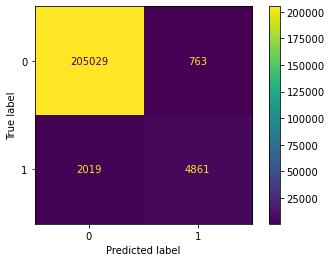


Confusion matrix on test set : 


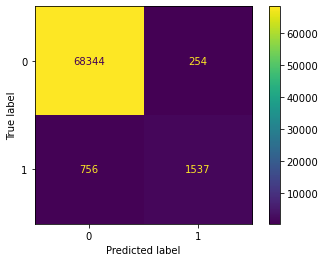

In [22]:
# lets asses the performance of XGBoost with the f1 score
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred_xgb))
print("f1-score on test set : ", f1_score(y_test, y_test_pred_xgb))

# Check the confusion matrices to better understanf the model
print("Confusion matrix on train set : ")
cm_train = confusion_matrix(y_train, y_train_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=classifier.classes_)
disp.plot()
plt.show()
print()
print("Confusion matrix on test set : ")
cm_test = confusion_matrix(y_test, y_test_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classifier.classes_)
disp.plot()
plt.show()

- <font size = 5>Already an improvement compared to Logistic regression using only ```total_pages_visited```</font>
- <font size = 5>Decrease in false negative and increase in true positives</font>
- <font size = 5>Age and total pages visited are the most important features but since we don't have that much let's just use them all</font>

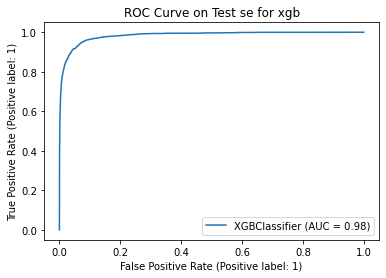

In [23]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test se for xgb")
RocCurveDisplay.from_estimator(xgb, X_test, y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

### <ins>Lets see how different models perform on this dataset</ins> 

In [24]:
# lets use all the features
features_list = ['total_pages_visited', 'age', 'new_user', 'country', 'source']
numeric_indices = [0, 1]
categorical_indices = [2, 3, 4]
target_variable = 'converted'

X5 = data.loc[:, features_list]
y5 = data.loc[:, target_variable]
print('EX5planatory variables : ', X5.columns)
print()

# Divide dataset in Train set & Test set 
print("Dividing into train and test sets...")
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, random_state = 0, stratify = y5)
print("...Done.")
print()

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X5_train = X5_train.values
X5_test = X5_test.values
y5_train = y5_train.values
y5_test = y5_test.values
print("...Done")

print(X5_train[0:3,:])
print(X5_test[0:3,:])
print()
print(y5_train[0:3])
print(y5_test[0:3])

# lets perform the required preprocessing
print("Encoding categorical features and standardizing numerical features...")

categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

featureencoder = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices),
        ]
    )

X5_train = featureencoder.fit_transform(X5_train)
X5_test = featureencoder.transform(X5_test)
print("...Done")
print(X5_train[0:3,:])

EX5planatory variables :  Index(['total_pages_visited', 'age', 'new_user', 'country', 'source'], dtype='object')

Dividing into train and test sets...
...Done.

Convert pandas DataFrames to numpy arrays...
...Done
[[6 40 1 'UK' 'Ads']
 [6 35 1 'US' 'Seo']
 [7 45 1 'China' 'Seo']]
[[4 25 0 'Germany' 'Direct']
 [5 43 1 'US' 'Ads']
 [5 39 1 'US' 'Direct']]

[0 0 0]
[0 0 0]
Encoding categorical features and standardizing numerical features...
...Done
[[0.33555591 1.17745176 1.         0.         1.         0.
  0.         0.        ]
 [0.33555591 0.56066916 1.         0.         0.         1.
  0.         1.        ]
 [0.63434609 1.79423436 1.         0.         0.         0.
  0.         1.        ]]


In [25]:
# fit all the models in the function on the data with 5 features for prediction
scores_5, classifier_5 = classif_model_testing(X5_train, X5_test, y5_train, y5_test)

[18:59:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:08] WARNING: /Users/runner/miniforge3/cond

In [26]:
# display the dataframe of all the scores
display(scores_5)

print(f"The classifier getting the highest f1-score on the test set using the five features is {classifier_5}")

,LogReg,Ridge,DecisionTree,SVC,AdaBoost,Bagging,GradBoost,Random_Forest,XGBoost
mean_f1_train,0.763982,0.106873,0.714766,0.750431,0.757408,0.727601,0.762495,0.734279,0.758017
std_f1_train,0.009987,0.017123,0.006527,0.011545,0.007092,0.01077,0.009648,0.009213,0.01338
f1_test,0.758183,0.108086,0.718919,0.741266,0.739975,0.725269,0.756943,0.731131,0.752693
c_mat_train,"[[204976, 816], [2116, 4764]]","[[205792, 0], [6491, 389]]","[[205313, 479], [1940, 4940]]","[[205171, 621], [2350, 4530]]","[[205092, 700], [2336, 4544]]","[[205129, 663], [1800, 5080]]","[[205006, 786], [2148, 4732]]","[[205166, 626], [1793, 5087]]","[[205029, 763], [2019, 4861]]"
c_mat_test,"[[68349, 249], [741, 1552]]","[[68598, 0], [2162, 131]]","[[68284, 314], [830, 1463]]","[[68405, 193], [829, 1464]]","[[68393, 205], [826, 1467]]","[[68230, 368], [779, 1514]]","[[68362, 236], [753, 1540]]","[[68260, 338], [777, 1516]]","[[68344, 254], [756, 1537]]"


The classifier getting the highest f1-score on the test set using the five features is LogisticRegression()


## Part III: Train the best classifier on all data and use it to make predictions on X_without_labels

### <ins>Training on entire dataset</ins>

In [28]:
# instantiate the logistic regressor
logreg_classif = LogisticRegression()

# Concatenate our train and test set to train your best classifier on all data with labels
X_all = np.append(X5_train,X5_test,axis=0)
y_all = np.append(y5_train,y5_test)

# fit the model to the data
logreg_classif.fit(X_all,y_all)
print("Model fitted to all the data")

# asses the performance of the model
y_pred = logreg_classif.predict(X_all)
print(f"f1-score of the model trained on all the data: {f1_score(y_pred, y_all)}")

Model fitted to all the data
f1-score of the model trained on all the data: 0.7635902391882097


In [29]:
# lets see our feature importance for the logistic regression
col_names = ['total_pages_visited', 'age'] + list(featureencoder.transformers_[1][1].get_feature_names())
data = logreg_classif.coef_
imp_feat = pd.DataFrame(columns=col_names, data=data)
display(imp_feat)

,total_pages_visited,age,x0_1,x1_Germany,x1_UK,x1_US,x2_Direct,x2_Seo
0,2.538645,-0.605902,-1.7261,3.641362,3.48068,3.131365,-0.21356,-0.028737


- <font size = 5>For the logistic regression, the country of origin seems to be important for the prediction.</font>
- <font size = 5>It might be interestiong to categorize country of origin as being rom the US (1) or not (0)</font>

- <font size = 5>Being a new user (x0_1) is negatively correlated to conversion, which was observed in the graphs during EDA</font>
- <font size = 5>Age is also to a certaine extent negativey correlated with conversion => the older you are the less likely you are to convert</font>
- <font size = 5>As already seen, total pages visited is positively correlated to conversion</font>

### <ins>Preprocessing the dataset without targets</ins>

In [30]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list_5 = ['total_pages_visited', 'age', 'new_user', 'country', 'source']
numeric_indices_5 = [0, 1]
categorical_indices_5 = [2, 3, 4]
X_without_labels = data_without_labels.loc[:, features_list_5]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])


# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16 28 0 'UK' 'Seo']
 [5 22 1 'UK' 'Direct']
 [1 32 1 'China' 'Seo']
 [6 32 1 'US' 'Ads']
 [3 25 0 'China' 'Seo']]
Encoding categorical features and standardizing numerical features...
...Done
[[ 3.32345775 -0.30282647  0.          0.          1.          0.
   0.          1.        ]
 [ 0.03676573 -1.04296559  1.          0.          1.          0.
   1.          0.        ]
 [-1.15839501  0.1905996   1.          0.          0.          0.
   0.          1.        ]
 [ 0.33555591  0.1905996   1.          0.          0.          1.
   0.          0.        ]
 [-0.56081464 -0.67289603  0.          0.          0.          0.
   0.          1.        ]]


In [31]:
from sklearn.metrics import RocCurveDisplay

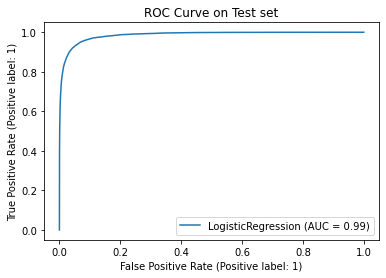

In [32]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(logreg_classif, X_all, y_all, ax=ax) # RocCurveDisplay from sklearn
plt.show()


### <ins>Making predictions on the data without targets</ins>

In [33]:
# Lets make our predictions and save them to a csv file for posting

data = {
    'converted': logreg_classif.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(data)
Y_predictions.to_csv('predictions/Nicolas_model1.csv', index=False)


### <ins>Possible improvement to implement in the model:</ins> <br>

- <font size = 4>Feature engineering on country of origin? Categorize as being from US or not, or from Europe or not</font>
- <font size = 4>Perform GridSearchCV with LogisticRegressor and other models to see if we can imrpove the predictions</font>

### <ins>What to do to improve conversion rate:</ins> <br>

- <font size = 4>Get people to stay longer on the website</font>
- <font size = 4>Try to understand why older people don't convert => maybe wrong topics for older people?</font>
- <font size = 4>Increase presence in Europe since conversion rate in UK and Germany are higher..or work on the US since more users but less conversion</font>
